In [ ]:
!pip install highway-env

# Setup: Import Libraries and Configuration

In [58]:
# Import necessary libraries
import gymnasium as gym
import highway_env
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
import time
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"


# Local imports
from config import config  # Import the configuration settings from config.py.

# Initialize and Configure the Reinforcement Learning Environment


In [59]:
import gymnasium as gym
import highway_env


env = gym.make("highway-fast-v0",render_mode='rgb_array')
env.unwrapped.configure(config)

# Explore Environment's Action and Observation Spaces

In [29]:
# get actions
action_space = env.action_space
observation_space = env.observation_space
print(action_space)
print(observation_space)

Discrete(9)
Box(-inf, inf, (7, 8, 8), float32)


In [30]:
# How many actions we have?
print(env.action_space)

Discrete(9)


In [31]:
# How many observations we have?
print(env.observation_space)


Box(-inf, inf, (7, 8, 8), float32)


In [32]:
env.observation_space.shape[0]

7

# Deep Q-Network Algorithm
Deep Q-Network (DQN) is an advanced reinforcement learning algorithm that integrates deep neural networks with Q-learning. The key innovation in DQN is the use of a neural network to approximate the Q-value function, which evaluates the quality of particular actions taken in specific states. This allows DQN to handle environments with high-dimensional observation spaces that traditional Q-learning can't manage effectively. Additionally, DQN employs techniques such as experience replay and fixed Q-targets to stabilize the training process and improve convergence.

## Replay Buffer:
A replay buffer is a data structure used in reinforcement learning to store transitions experienced by the agent during interaction with the environment. By randomly sampling from this buffer to train the agent, it helps break the correlation between consecutive learning samples and stabilizes the learning process.

In [33]:
class ReplayBuffer:
    """A simple FIFO (First In, First Out) buffer for storing experience tuples."""
    def __init__(self, capacity):
        """
        Initialize the replay buffer with a fixed capacity.
        Args:
            capacity (int): The maximum number of transitions to store in the buffer.
        """
        self.capacity = capacity  # Maximum number of elements in the buffer
        self.memory = []  # Internal list to hold the experiences
        self.position = 0  # Current position in the circular buffer

    def push(self, state, action, reward, terminated, next_state):
        """
        Add a transition tuple to the buffer.
        Args:
            state: The state of the environment before taking the action.
            action: The action taken.
            reward: The reward received after taking the action.
            terminated: Boolean flag indicating if the episode has ended.
            next_state: The state of the environment after taking the action.
        """
        # If buffer is not full, append a slot
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        # Store the transition at the current position in a circular manner
        self.memory[self.position] = (state, action, reward, terminated, next_state)
        # Update position
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        Args:
            batch_size (int): The number of transitions to sample.
        Returns:
            List[Tuple]: A list of randomly sampled transitions.
        """
        return random.choices(self.memory, k=batch_size)  # Return randomly chosen samples

    def __len__(self):
        """
        Return the current size of internal memory.
        """
        return len(self.memory)  # Number of elements in the buffer

# Example of creating and using a replay buffer
#replay_buffer = ReplayBuffer(1000)
# Now you can push transitions to the buffer and sample from it as needed.


## Neural network:
A neural network in the context of Deep Q-Networks (DQN) serves as a function approximator to estimate the action-value function, which predicts the expected reward for each action taken in a given state. This allows the DQN to learn optimal policies by updating the neural network's weights based on the temporal differences in observed rewards, facilitating efficient decision-making in complex environments.

In [34]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        # Initialize the base class from nn.Module, necessary for all PyTorch networks.

        # Define the first fully connected layer (fc1) from input to hidden layer.
        self.fc1 = nn.Linear(input_size, hidden_size)

        # Define the second fully connected layer (fc2) from hidden to output layer.
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The forward pass defines how the data flows through the network from input to output.

        # Flatten the input tensor to fit the expected input of the first layer if not already flat.
        x = x.view(x.size(0), -1)

        # Apply a ReLU activation function to the output of the first layer for non-linearity.
        x = F.relu(self.fc1(x))

        # The output layer receives the activated output from the hidden layer.
        x = self.fc2(x)
        return x


## DQN

In [35]:
class DQN:
    """
    Deep Q-Network (DQN) implementation for reinforcement learning.
    This class encapsulates the learning algorithm which utilizes a neural network
    to estimate Q-values for each action given a state.
    """
    def __init__(self,
                action_space,
                observation_space,
                gamma,
                batch_size,
                buffer_capacity,
                update_target_every,
                epsilon_start,
                decrease_epsilon_factor,
                epsilon_min,
                learning_rate,
                ):
        """
        Initializes a new instance of the DQN class.

        Parameters:
            action_space: The space of all possible actions.
            observation_space: The space of all possible states.
            gamma: Discount factor for future rewards.
            batch_size: Number of samples per batch for network updates.
            buffer_capacity: Maximum size of the buffer for storing transitions.
            update_target_every: Number of steps between updates to the target network.
            epsilon_start: Initial value of epsilon for the epsilon-greedy policy.
            decrease_epsilon_factor: Rate at which epsilon decreases.
            epsilon_min: Minimum value of epsilon.
            learning_rate: Learning rate for the optimizer.
        """
        self.action_space = action_space
        self.observation_space = observation_space
        self.gamma = gamma

        self.batch_size = batch_size
        self.buffer_capacity = buffer_capacity
        self.update_target_every = update_target_every

        self.epsilon_start = epsilon_start
        self.decrease_epsilon_factor = decrease_epsilon_factor # larger -> more exploration
        self.epsilon_min = epsilon_min

        self.learning_rate = learning_rate

        self.reset()

    def get_action(self, state,epsilon = None):
        """
        Determine the action to take based on the current state and epsilon-greedy policy.

        Parameters:
            state: Current state of the environment.
            epsilon: Exploration rate, if None uses the current epsilon value.

        Returns:
            The action to take as an integer.
        """
        if epsilon is None:
            epsilon = self.epsilon
        if np.random.rand() < epsilon:
            return self.action_space.sample()
        else:
            q_values = self.get_q(state)
            return np.argmax(q_values)

    def update(self, state, action, reward, terminated, next_state):
        """
        Update the model based on the state transition.

        Parameters:
            state: The initial state.
            action: The action taken.
            reward: The reward received after taking the action.
            terminated: Whether the episode has ended.
            next_state: The state after taking the action.

        Returns:
            The loss value as a float, indicating how well the prediction matched the expected outcome.
        """
        self.buffer.push(
            torch.tensor(state,dtype=torch.float32).unsqueeze(0),
            torch.tensor([[action]],dtype=torch.int64),
            torch.tensor([reward],dtype=torch.float32),
            torch.tensor([terminated], dtype=torch.int64),
            torch.tensor(next_state).unsqueeze(0)
        )

        if len(self.buffer) < self.batch_size:
            return np.inf

        # get batches
        transitions = self.buffer.sample(self.batch_size)

        state_batch, action_batch, reward_batch, terminated_batch, next_state_batch = tuple(
            [torch.cat(data) for data in zip(*transitions)]
        )



        #print(action_batch.shape)
        #print(state_batch.shape)

        values = self.q_net.forward(state_batch).gather(1, action_batch)

        # Compute the ideal Q values
        with torch.no_grad():
            next_state_values = (1 - terminated_batch) * self.target_net(
                next_state_batch
            ).max(1)[0]
            targets = next_state_values * self.gamma + reward_batch

        loss = self.loss_function(values, targets.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if not ((self.n_steps + 1) % self.update_target_every):
            self.target_net.load_state_dict(self.q_net.state_dict())

        self.decrease_epsilon()

        self.n_steps += 1
        if terminated:
            self.n_eps += 1

        return loss.detach().numpy()


    def get_q(self, state):
        """
        Compute the Q-values for all actions given a state using the Q-network.

        Parameters:
            state: The state for which to compute Q-values.

        Returns:
            A numpy array of Q-values for each action.
        """
        state_tensor = torch.tensor(state).unsqueeze(0)
        #print(state_tensor.shape[0])
        with torch.no_grad():
            output = self.q_net.forward(state_tensor) # shape (1,  n_actions)

        return output.numpy()[0]  # shape  (n_actions)

    def decrease_epsilon(self):
        """
        Decrease the epsilon value based on the exponential decay rate.
        """
        self.epsilon = self.epsilon_min + (self.epsilon_start - self.epsilon_min) * (
                        np.exp(-1. * self.n_eps / self.decrease_epsilon_factor ) )

    def reset(self):
        """
        Reset the DQN model, initializing or re-initializing its components.
        This includes setting up the networks, optimizer, and loss function.
        """
        hidden_size = 128

        obs_size = 7*8*8
        #print(obs_size)
        n_actions = self.action_space.n

        self.buffer = ReplayBuffer(self.buffer_capacity)
        self.q_net =  Net(obs_size, hidden_size, n_actions)
        self.target_net = Net(obs_size, hidden_size, n_actions)

        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.q_net.parameters(), lr=self.learning_rate)

        self.epsilon = self.epsilon_start
        self.n_steps = 0
        self.n_eps = 0


## Evaluation of the Agent

In [36]:
def eval_agent(agent, env, n_sim=5):
    """

    Monte Carlo evaluation of DQN agent.

    Repeat n_sim times:
        * Run the DQN policy until the environment reaches a terminal state (= one episode)
        * Compute the sum of rewards in this episode
        * Store the sum of rewards in the episode_rewards array.
    """
    env_copy = deepcopy(env)
    episode_rewards = np.zeros(n_sim)
    for i in range(n_sim):
        state, _ = env_copy.reset()
        reward_sum = 0
        done = False
        while not done:
            action = agent.get_action(state, 0)
            state, reward, terminated, truncated, _ = env_copy.step(action)
            reward_sum += reward
            done = terminated or truncated
        episode_rewards[i] = reward_sum

    return episode_rewards

# Training

In [37]:
import cv2
import gym
from pathlib import Path
import numpy as np
from IPython.display import HTML
from base64 import b64encode

class RecordVideos(gym.Wrapper):
    def __init__(self, env, save_dir="videos", fps=20):
        super().__init__(env)
        self.frames = []
        self.save_dir = Path(save_dir)
        self.fps = fps
        self.save_dir.mkdir(parents=True, exist_ok=True)
        self.video_path = None

    def reset(self, **kwargs):
        self.frames = []
        return super().reset(**kwargs)

    def step(self, action):
        observation, reward, done, truncated, info = super().step(action)
        self.frames.append(self.env.render())
        return observation, reward, done, truncated, info

    def close(self):
        if self.frames:
            self.save_video()
        super().close()

    def save_video(self):
        video_id = len(list(self.save_dir.glob("*.avi"))) + 1
        self.video_path = self.save_dir / f"episode_{video_id}.avi"
        frame_size = (self.frames[0].shape[1], self.frames[0].shape[0])
        out = cv2.VideoWriter(str(self.video_path), cv2.VideoWriter_fourcc(*'DIVX'), self.fps, frame_size)
        for frame in self.frames:
            out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        out.release()

def record_videos(env):
    return RecordVideos(env)


In [40]:
import gymnasium as gym
import highway_env


env = gym.make("highway-fast-v0",render_mode='rgb_array')
env.unwrapped.configure(config)

In [41]:
# Setup the environment's action and observation spaces
env = record_videos(env)  # Wrap the environment to enable video recording
action_space = env.action_space
observation_space = env.observation_space

# Initialize DQN parameters
gamma = 0.8  # Discount factor for future rewards
batch_size = 128  # Number of experiences to sample from buffer
buffer_capacity = 15000  # Total size of experience replay buffer
update_target_every = 50  # Frequency of target network update

# Setup for epsilon-greedy strategy
epsilon_start = 0.9  # Initial epsilon value for exploration
decrease_epsilon_factor = 1000  # Rate at which epsilon decreases
epsilon_min = 0.005  # Minimum epsilon value for exploration

# Learning rate for the optimizer
learning_rate = 5e-4

# Grouping all parameters together for DQN initialization
arguments = (action_space, observation_space, gamma, batch_size, buffer_capacity,
             update_target_every, epsilon_start, decrease_epsilon_factor,
             epsilon_min, learning_rate)

# Set the number of episodes for training
N_episodes = 500

# Initialize the DQN agent with specified parameters
agent = DQN(*arguments)

def train(env, agent, N_episodes, eval_every=10, reward_threshold=300):
    """
    Train the DQN agent in the specified environment over a given number of episodes.

    Parameters:
        env: The environment in which the agent operates.
        agent: The DQN agent to train.
        N_episodes: Total number of episodes for training.
        eval_every: Evaluate the agent's performance every 'eval_every' episodes.
        reward_threshold: The reward threshold to determine if training should be stopped early.

    Returns:
        A tuple containing lists of losses, average rewards per evaluation period, and epsilon values during training.
    """
    total_time = 0  # Total timesteps taken
    losses = []  # To store loss values per episode
    avg_rewards = []  # To store average rewards per evaluation period
    epsilons = []  # To store epsilon values

    for ep in range(N_episodes):
        done = False
        state, _ = env.reset()  # Reset environment to start new episode
        episode_loss = []  # List to store losses per episode
        episode_rewards = []  # List to store rewards per episode

        while not done:
            action = agent.get_action(state)  # Determine action based on current state
            next_state, reward, terminated, truncated, _ = env.step(action)  # Take action in environment
            loss_val = agent.update(state, action, reward, terminated, next_state)  # Update the agent
            state = next_state  # Move to the next state
            episode_loss.append(loss_val)
            episode_rewards.append(reward)
            done = terminated or truncated  # Check if the episode is done
            total_time += 1

        losses.append(np.mean(episode_loss))  # Record average loss for this episode
        epsilons.append(agent.epsilon)  # Record current epsilon

        if ((ep + 1) % eval_every == 0):
            eval_rewards = eval_agent(agent, env)  # Evaluate the agent
            avg_reward = np.mean(eval_rewards)  # Calculate average reward
            avg_rewards.append(avg_reward)  # Append to list
            print(f"Episode = {ep+1}, Average Reward = {avg_reward}, Epsilon = {agent.epsilon}")
            if avg_reward >= reward_threshold:
                print("Reward threshold reached, stopping training.")
                break

    return losses, avg_rewards, epsilons


Episode = 10, Average Reward = 14.48125, Epsilon = 0.9
Episode = 20, Average Reward = 11.0375, Epsilon = 0.9
Episode = 30, Average Reward = 16.13125, Epsilon = 0.9
Episode = 40, Average Reward = 10.01875, Epsilon = 0.8991054473508706
Episode = 50, Average Reward = 12.64375, Epsilon = 0.8991054473508706
Episode = 60, Average Reward = 13.3125, Epsilon = 0.8991054473508706
Episode = 70, Average Reward = 15.1125, Epsilon = 0.8991054473508706
Episode = 80, Average Reward = 13.78125, Epsilon = 0.8991054473508706
Episode = 90, Average Reward = 12.4, Epsilon = 0.8991054473508706
Episode = 100, Average Reward = 17.14375, Epsilon = 0.8991054473508706
Episode = 110, Average Reward = 15.8375, Epsilon = 0.8991054473508706
Episode = 120, Average Reward = 8.33125, Epsilon = 0.8991054473508706
Episode = 130, Average Reward = 13.275, Epsilon = 0.8991054473508706
Episode = 140, Average Reward = 15.74375, Epsilon = 0.8991054473508706
Episode = 150, Average Reward = 12.8, Epsilon = 0.8991054473508706
Epis

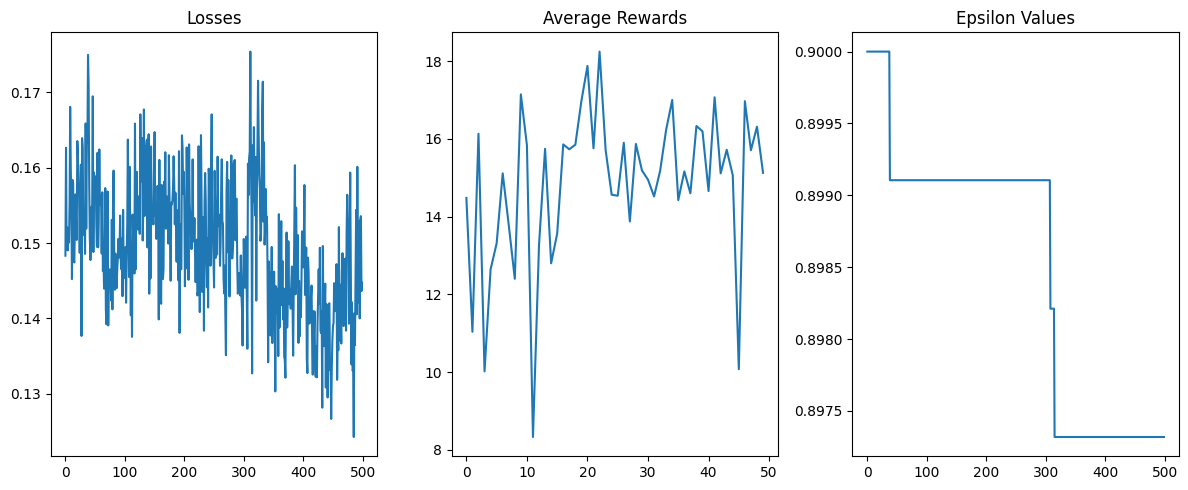

In [44]:
# Train the agent in the specified environment and collect the losses, average rewards, and epsilon values
losses, avg_rewards, epsilons = train(env, agent, N_episodes)



In [ ]:

# Plotting the results from the training process
plt.figure(figsize=(12, 5))  # Set the size of the overall figure

# Plotting the losses over each episode
plt.subplot(1, 3, 1)  # Prepare a subplot in a 1x3 grid, first position
plt.plot(losses)  # Plot the recorded losses
plt.title("Losses")  # Title of the plot indicating these are losses

# Plotting the average rewards received every evaluation period
plt.subplot(1, 3, 2)  # Prepare a subplot in a 1x3 grid, second position
plt.plot(avg_rewards)  # Plot the average rewards
plt.title("Average Rewards")  # Title of the plot indicating these are average rewards

# Plotting the epsilon values used during the training process
plt.subplot(1, 3, 3)  # Prepare a subplot in a 1x3 grid, third position
plt.plot(epsilons)  # Plot the epsilon values
plt.title("Epsilon Values")  # Title of the plot indicating these are the epsilon values

plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()  # Display the created plots

In [43]:
# Evaluate the final policy
rewards = eval_agent(agent, env, 20)
print("")
print("mean reward after training = ", np.mean(rewards))


mean reward after training =  15.809375
